# Digit Recognizer - Feed Foward Net

**Kyu Cho**  
**10/28/2016**

# Data
- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
- Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  
  
- The training data set, (train.csv), has 785 columns. 
- The first column, called "label", is the digit that was drawn by the user. 
- The rest of the columns contain the pixel-values of the associated image.  
  
- Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. 
- To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. 
- Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
    + For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

000 001 002 003 ... 026 027  
028 029 030 031 ... 054 055  
056 057 058 059 ... 082 083  
 |   |   |   |  ...  |   |  
728 729 730 731 ... 754 755  
756 757 758 759 ... 782 783   

# Techniques Used

1. Feed Forward
2. TODO: Drop out
3. Nesterov and RMSprop
4. Ragulization
5. Learning Rate
6. Batch Gradient
7. Normalization or PCA

# Table of Contents
1. Load Data
2. Split Data
3. Function initialization
4. Build Model

## Load Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

def get_normalized_data():
    print "Reading in and transforming data..."
    df = pd.read_csv('../large_files/train.csv')
    
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    
    Y = data[:, 0]
    X = data[:, 1:]
    
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    
    return X, Y

In [4]:
X, Y = get_normalized_data()
X.shape, Y.shape

Reading in and transforming data...


((42000, 784), (42000,))

## Split train and test set

In [5]:
Xtrain = X[:-1000,]
Ytrain = Y[:-1000]
Xtest  = X[-1000:,]
Ytest  = Y[-1000:]

In [6]:
Xtrain.shape, Ytrain.shape

((41000, 784), (41000,))

In [7]:
# create indicator matrix, represent digit in location for each row
# ex) digit 9 -> indicate 1 in 9th column
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10)) # digit has 0 to 9 (10 number)
    for i in xrange(N):
        ind[i, y[i]] = 1
    return ind

In [8]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Initialization

### Derivative function

In [9]:
# Z(last weight), T(target Y), T(predicted Y)
def derivative_w2(Z, T, Y):
    return Z.T.dot(Y - T)

def derivative_b2(T, Y):
    return (Y - T).sum(axis=0)

def derivative_w1(X, Z, T, Y, W2):
    # return X.T.dot(((Y-T).dot(W2.T) * (Z*(1-Z)))) # for sigmoid
    return X.T.dot(((Y-T).dot(W2.T) * np.sign(Z))) # for relu

def derivative_b1(Z, T, Y, W2):
    # return ((Y-T).dot(W2.T) * (Z*(1-Z))).sum(axis=0) # for sigmoid
    return ((Y-T).dot(W2.T) * np.sign(Z)).sum(axis=0) # for relu

### Feed Foward and Cost function

In [10]:
def forward(X, W1, b1, W2, b2):
    Z = X.dot(W1) + b1 # 1st layer
    Z[Z < 0] = 0 # rulu or rectifier

    A = Z.dot(W2) + b2 # 2nd layer
    
    # softmax
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True) 
    
    return Y, Z

def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

def predict(p_y):
    return np.argmax(p_y, axis=1)

def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

## Build Model

In [11]:
def ANN(n_hdim):
    # Nesterov momentum
    
    # initialize hyper-parameters
    max_iter = 5  # 30 iteration for sigmoid
    print_period = 100 # print every 10 iterations
    lr = 0.00004 # learning rate
    reg = 0.01 # regulization rate
    batch_sz = 1000 # batch size
    N, D = Xtrain.shape # 41000, 784
    n_batches = N / batch_sz  # number of batches
    M = n_hdim # hidden layer dimention

    K = 10 # number of output '0' to '9' so 10 numbers

    # initialize weight and bias
    W1 = np.random.randn(D, M) / np.sqrt(D)  # 784x300
    b1 = np.zeros(M)
    W2 = np.random.randn(M, K) / np.sqrt(M)  # 300x10
    b2 = np.zeros(K)

    LL_nest = []
    CR_nest = []
    mu = 0.9
    dW2 = 0
    db2 = 0
    dW1 = 0
    db1 = 0

    for i in xrange(max_iter):
        for j in xrange(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates from backword w2
            dW2 = mu*mu*dW2 - (1 + mu)*lr*(derivative_w2(Z, Ybatch, pYbatch) + reg*W2)
            W2 += dW2
            db2 = mu*mu*db2 - (1 + mu)*lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)
            b2 += db2
            dW1 = mu*mu*dW1 - (1 + mu)*lr*(derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
            W1 += dW1
            db1 = mu*mu*db1 - (1 + mu)*lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)
            b1 += db1

            if j % print_period == 0:
                # calculate just for LL
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                # print "pY:", pY
                ll = cost(pY, Ytest_ind)
                LL_nest.append(ll)
                print "[Nesterov] Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll)

                err = error_rate(pY, Ytest)
                CR_nest.append(err)
                print "Error rate:", err
    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print "Final error rate:", error_rate(pY, Ytest)

    
    # RMSprop
    
    W1 = np.random.randn(D, M) / np.sqrt(D)
    b1 = np.zeros(M)
    W2 = np.random.randn(M, K) / np.sqrt(M)
    b2 = np.zeros(K)
    
    LL_rms = []
    CR_rms = []
    lr0 = 0.001 # if you set this too high you'll get NaN!
    cache_W2 = 0
    cache_b2 = 0
    cache_W1 = 0
    cache_b1 = 0
    decay_rate = 0.999
    eps = 0.0000000001
    for i in xrange(max_iter):
        for j in xrange(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            # updates
            gW2 = derivative_w2(Z, Ybatch, pYbatch) + reg*W2
            cache_W2 = decay_rate*cache_W2 + (1 - decay_rate)*gW2*gW2
            W2 -= lr0 * gW2 / (np.sqrt(cache_W2) + eps)

            gb2 = derivative_b2(Ybatch, pYbatch) + reg*b2
            cache_b2 = decay_rate*cache_b2 + (1 - decay_rate)*gb2*gb2
            b2 -= lr0 * gb2 / (np.sqrt(cache_b2) + eps)

            gW1 = derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1
            cache_W1 = decay_rate*cache_W1 + (1 - decay_rate)*gW1*gW1
            W1 -= lr0 * gW1 / (np.sqrt(cache_W1) + eps)

            gb1 = derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1
            cache_b1 = decay_rate*cache_b1 + (1 - decay_rate)*gb1*gb1
            b1 -= lr0 * gb1 / (np.sqrt(cache_b1) + eps)

            if j % print_period == 0:
                # calculate just for LL
                pY, _ = forward(Xtest, W1, b1, W2, b2)
                # print "pY:", pY
                ll = cost(pY, Ytest_ind)
                LL_rms.append(ll)
                print "[RMSprop] Cost at iteration i=%d, j=%d: %.6f" % (i, j, ll)

                err = error_rate(pY, Ytest)
                CR_rms.append(err)
                print "Error rate:", err

    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print "Final error rate:", error_rate(pY, Ytest)

    plt.plot(LL_nest, label="nesterov")
    plt.plot(LL_rms, label='rms')
    plt.legend()
    plt.show()

[Nesterov] Cost at iteration i=0, j=0: 2271.052469
Error rate: 0.848
[Nesterov] Cost at iteration i=1, j=0: 231.862098
Error rate: 0.065
[Nesterov] Cost at iteration i=2, j=0: 179.244283
Error rate: 0.051
[Nesterov] Cost at iteration i=3, j=0: 152.886985
Error rate: 0.048
[Nesterov] Cost at iteration i=4, j=0: 137.513014
Error rate: 0.042
Final error rate: 0.04
[RMSprop] Cost at iteration i=0, j=0: 1299.770248
Error rate: 0.332
[RMSprop] Cost at iteration i=1, j=0: 142.045097
Error rate: 0.04
[RMSprop] Cost at iteration i=2, j=0: 114.654678
Error rate: 0.03
[RMSprop] Cost at iteration i=3, j=0: 105.590717
Error rate: 0.032
[RMSprop] Cost at iteration i=4, j=0: 101.233008
Error rate: 0.03
Final error rate: 0.029


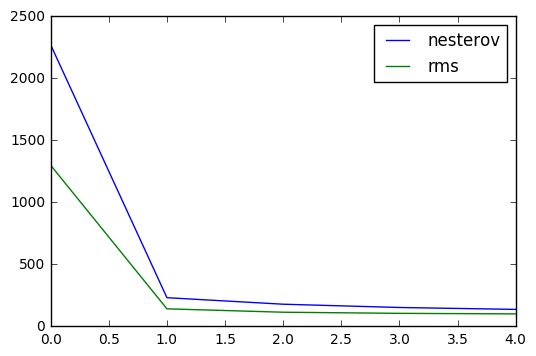

[Nesterov] Cost at iteration i=0, j=0: 2164.714889
Error rate: 0.804
[Nesterov] Cost at iteration i=1, j=0: 228.474215
Error rate: 0.065
[Nesterov] Cost at iteration i=2, j=0: 179.365309
Error rate: 0.048
[Nesterov] Cost at iteration i=3, j=0: 155.718158
Error rate: 0.043
[Nesterov] Cost at iteration i=4, j=0: 142.466788
Error rate: 0.037
Final error rate: 0.035
[RMSprop] Cost at iteration i=0, j=0: 4883.351719
Error rate: 0.453
[RMSprop] Cost at iteration i=1, j=0: 219.252411
Error rate: 0.054
[RMSprop] Cost at iteration i=2, j=0: 116.293336
Error rate: 0.033
[RMSprop] Cost at iteration i=3, j=0: 105.069615
Error rate: 0.031
[RMSprop] Cost at iteration i=4, j=0: 130.141062
Error rate: 0.029
Final error rate: 0.032


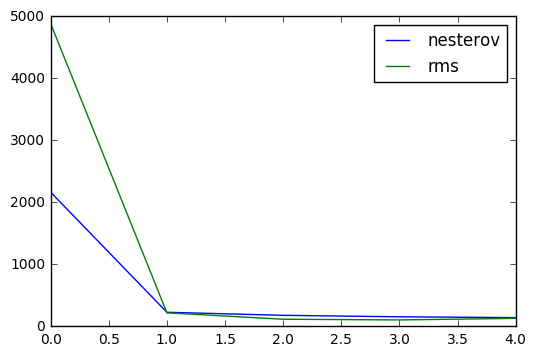

[Nesterov] Cost at iteration i=0, j=0: 2043.469486
Error rate: 0.684
[Nesterov] Cost at iteration i=1, j=0: 216.948907
Error rate: 0.058
[Nesterov] Cost at iteration i=2, j=0: 173.036703
Error rate: 0.046
[Nesterov] Cost at iteration i=3, j=0: 151.952908
Error rate: 0.039
[Nesterov] Cost at iteration i=4, j=0: 140.219855
Error rate: 0.038
Final error rate: 0.036
[RMSprop] Cost at iteration i=0, j=0: 7075.368585
Error rate: 0.337
[RMSprop] Cost at iteration i=1, j=0: 414.306987
Error rate: 0.054
[RMSprop] Cost at iteration i=2, j=0: 241.374453
Error rate: 0.04
[RMSprop] Cost at iteration i=3, j=0: 176.364345
Error rate: 0.039
[RMSprop] Cost at iteration i=4, j=0: 220.355203
Error rate: 0.035
Final error rate: 0.034


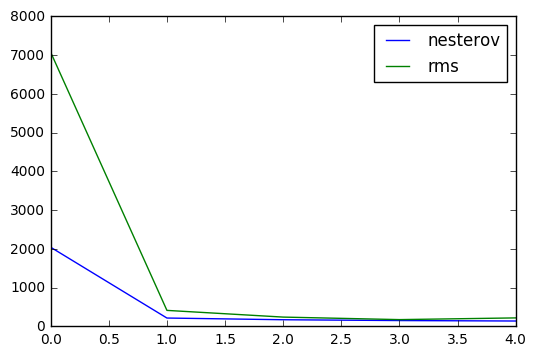

[Nesterov] Cost at iteration i=0, j=0: 1874.225557
Error rate: 0.595
[Nesterov] Cost at iteration i=1, j=0: 212.491874
Error rate: 0.056
[Nesterov] Cost at iteration i=2, j=0: 160.154627
Error rate: 0.044
[Nesterov] Cost at iteration i=3, j=0: 138.849506
Error rate: 0.036
[Nesterov] Cost at iteration i=4, j=0: 124.146197
Error rate: 0.031
Final error rate: 0.034
[RMSprop] Cost at iteration i=0, j=0: 9342.011869
Error rate: 0.344
[RMSprop] Cost at iteration i=1, j=0: 600.306416
Error rate: 0.058
[RMSprop] Cost at iteration i=2, j=0: 1625.858590
Error rate: 0.067
[RMSprop] Cost at iteration i=3, j=0: 381.446910
Error rate: 0.033
[RMSprop] Cost at iteration i=4, j=0: 314.504445
Error rate: 0.034
Final error rate: 0.035


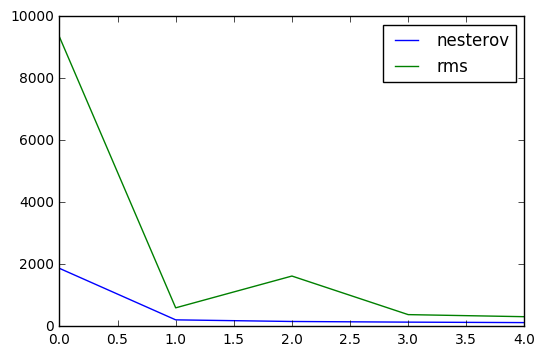

In [12]:
if __name__ == '__main__':
    ANN(n_hdim = 100)
    ANN(n_hdim = 500)
    ANN(n_hdim = 1000)
    ANN(n_hdim = 1500)

- Interesting result
    + Nesterov drops the error rate faster but rms eventually got better.